# Logistic Regression On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Conclusion<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Logistic Regression algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
# loading required libraries 
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

import warnings 
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

#Applying dimensionality reduction 
def truncated_svd(data):
    svd = TruncatedSVD(n_components = 100, random_state = 0)
    svd_val = svd.fit_transform(data)
    return svd_val

## 3. Loading the data

In [4]:
#Loading the data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

Loaded data is imbalanced and logistic regression is very sensitive to imbalanced data as well as to mismatch between the class distribution of train-set and test-set. So, it is a good idea to upsample or downsample the data to balance the two classes. Here, I'm downsampling my data. 

In [6]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
from sklearn.utils import resample

df_majority = data[data.Score=='positive']
df_minority = data[data.Score=='negative']
 
# downsampling majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=57110,  
                                 random_state=1)   
 
# combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [8]:
df_downsampled.shape

(114220, 12)

In [9]:
# sorting the data according to the time-stamp
sorted_data = df_downsampled.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
241,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
296,346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,positive,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp explor inc...


In [10]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [11]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
241,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
296,346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp explor inc...


In [12]:
score = np.array(sorted_data.Score.reshape(114220,1))

## 5. Function Definitions

### [A.] Data Spliting 

In [13]:
# spliting the data
def data_split(data, score):
    # train data 70% and test data 30%
    train_x, test_x, train_y, test_y = cross_validation.train_test_split(data, score, test_size=0.3, random_state=0)    
    return train_x, test_x, train_y, test_y

### [B.] Logistic Regression

In [14]:
# applying logistic regression with both L1 and L2 normalization
def logistic_regression(data, score):
    train_x, test_x, train_y, test_y = data_split(data, score)
    cv_err_l1 = []
    test_err_l1 = []
    cv_err_l2 = []
    test_err_l2 = []
    w_nonz = []
    penalty = ['l1', 'l2']
    c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=36)
    for train_data, cv_data in Kfold.split(train_x):
        for l in penalty:
            for c in c_val:
                lr_model = LogisticRegression(penalty = l, C = c, random_state = 36, n_jobs = 6)
                lr_model.fit(train_x[train_data], train_y[train_data])
                if l == 'l1':
                    cv_err_l1.append(1 - (lr_model.score(train_x[cv_data], train_y[cv_data])))
                    test_err_l1.append(1 - (lr_model.score(test_x, test_y)))
                    w_nonz.append(np.count_nonzero(lr_model.coef_))
                else :
                    cv_err_l2.append(1 - (lr_model.score(train_x[cv_data], train_y[cv_data])))
                    test_err_l2.append(1 - (lr_model.score(test_x, test_y)))
    return cv_err_l1, test_err_l1, cv_err_l2, test_err_l2, w_nonz

### [C.] Error Curve 

In [15]:
# comparing error between cv and test data
def error_comparision(cv_err, test_err):
    sns.set()
    c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(c_val, cv_err[i,:],label = 'cv_error')
        plt.plot(c_val, test_err[i,:],label = 'test_error')
        plt.xscale('log')
        plt.xlabel('C-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TEST-ERR for Fold '+str(i+1))

### [D.] Accuracy Metrics 

In [16]:
# test accuracy and ROC plot
def final_test_acc(data,score,l,best_c,name):
    train_x, test_x, train_y, test_y = data_split(data, score)
    lr_model = LogisticRegression(penalty = l, C = best_c, random_state = 36, n_jobs = 6)
    lr_model.fit(train_x,train_y)
    pred = lr_model.predict(test_x)
    acc = accuracy_score(test_y, pred, normalize=True) * float(100)
    print("\nTest accuracy for C = '{0}' is '{1}'".format(best_c, acc))
    
    y_pred_proba = lr_model.predict_proba(test_x)[::,1]
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('Logistic-Regression ROC curve for '+name)
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_y, y_pred_proba))
    conf_matx = confusion_matrix(test_y,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(norm_conf_matx, annot=True, xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)

### [E.] Grid Search 

In [17]:
# applying grid search to find best c 
def grid_search_cv(data, score, l):
    
    train_x, test_x, train_y, test_y = data_split(data, score)
    tuned_parameters = [{'C': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]}]
    
    model = GridSearchCV(LogisticRegression(penalty=l), tuned_parameters, scoring = 'f1', cv=3)
    model.fit(train_x, train_y.reshape(train_x.shape[0],))

    print(model.best_estimator_)
    print(model.score(test_x, test_y))

### [F.] Random Search 

In [18]:
# applying random search to find best c 
def random_search_cv(data, score, l):
    
    train_x, test_x, train_y, test_y = data_split(data, score)
    tuned_parameters={'C': scipy.stats.norm(10)}
    model = RandomizedSearchCV(LogisticRegression(penalty=l), tuned_parameters, scoring = 'f1', cv=3)
    model.fit(train_x,train_y)
                                                                                   
    print(model.best_estimator_)
    print(model.score(test_x, test_y))

### [G.] Multicollinearity Test

In [19]:
# checking the severity of multicollinearity 
def multi_colinearity_test(data, score, c):
    train_x, test_x, train_y, test_y = data_split(data, score)
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 36, n_jobs = 6)
    lr.fit(train_x, train_y)
    coef_before = lr.coef_
    
    # adding small perturbation
    train_x.data += train_x.data.min()
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 36, n_jobs = 6)
    lr.fit(train_x, train_y)
    coef_after = lr.coef_
    dist = np.linalg.norm(coef_after-coef_before)
    
    # effect of petubation in terms of euclidean distance
    print("Euclidean distance between these two weight vectors is ", dist)
    
    # effect of pertubation in terms of cosine distance 
    cos = np.dot(coef_after, coef_before.T) / (np.linalg.norm(coef_after) * np.linalg.norm(coef_before))
    print("\nCosine similarity between these two weight vectors is ", cos[0,0])
    print("\ni.e the angle between them is ", np.rad2deg(np.arccos(cos))[0,0])

### [H.] Top Features Selection

In [20]:
# finding top features for each class
def top_features(data, score, vectorizer, top_n, c):
    train_x, test_x, train_y, test_y = data_split(data, score)
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 36, n_jobs = 6)
    lr.fit(train_x, train_y)
    
    # sorting the weight indices 
    pos_class_weight_sorted = -lr.coef_.argsort()
    neg_class_weight_sorted = lr.coef_.argsort()
    
    # top negative features
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    neg = np.take(vectorizer.get_feature_names(), neg_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(neg[0][i])
        
    # top positive features 
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    pos = np.take(vectorizer.get_feature_names(), pos_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(pos[0][i])

## 6. Bag of Words (BoW)

In [21]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(sorted_data['CleanedText'].values)

In [22]:
final_counts.shape

(114220, 41258)

In [46]:
# column standardization 
#final_counts = standardizer(final_counts)

I'm skipping the column standardization because without it the logistic regression performs a little bit better on this dataset.<br>
(I've already tested accuracy measures on standardized data, the above code here is only for demonstration purpose)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [23]:
# applying both L1 & L2 normalized logisticr regression 
cv_l1_bow, test_l1_bow, cv_l2_bow, test_l2_bow, w_nonz = logistic_regression(final_counts, score)

In [24]:
# reshaping the cv and test error over 3-Fold cv 
cv_l1_bow = np.reshape(cv_l1_bow,(3, 17))
test_l1_bow = np.reshape(test_l1_bow,(3, 17))
cv_l2_bow = np.reshape(cv_l2_bow,(3, 17))
test_l2_bow = np.reshape(test_l2_bow,(3, 17))

In [25]:
# effect of λ on sparsity of weight vector in L1 normalization 
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =         3
C =     0.0010      λ =  1000.0000      nonzero_w =        12
C =     0.0050      λ =   200.0000      nonzero_w =        92
C =     0.0100      λ =   100.0000      nonzero_w =       181
C =     0.0500      λ =    20.0000      nonzero_w =       610
C =     0.1000      λ =    10.0000      nonzero_w =       976
C =     0.5000      λ =     2.0000      nonzero_w =      3022
C =     1.0000      λ =     1.0000      nonzero_w =      4564
C =     5.0000      λ =     0.2000      nonzero_w =      9030
C =    10.0000      λ =     0.1000      nonzero_w =     10481
C =    50.0000      λ =     0.0200      nonzero_w =     12758
C =   100.0000      λ =     0.0100      nonzero_w =     13600
C =   500.0000      λ =     0.0020      nonzero_w =     14917
C =  1000.0000      λ =     0.0010      nonzero_w =     15342
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

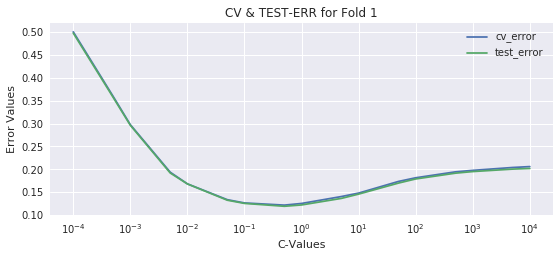

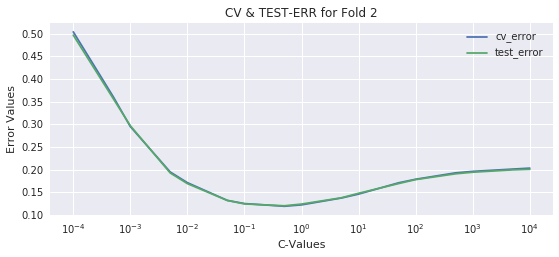

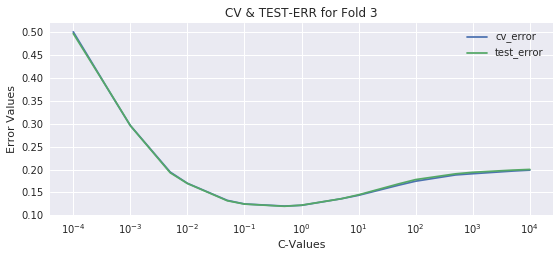

In [26]:
# cv error and test error for L1 normalization 
error_comparision(cv_l1_bow, test_l1_bow)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value ranging from 0.1 to 1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value rising becasue it overfits the model.

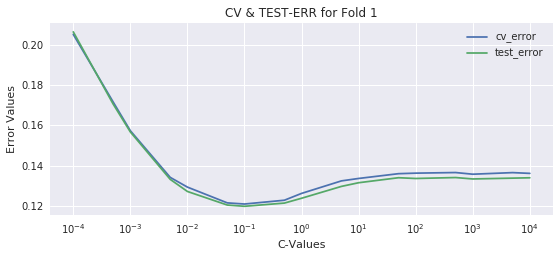

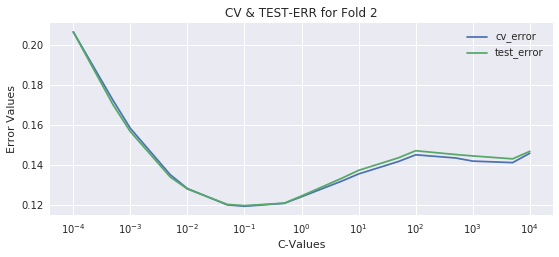

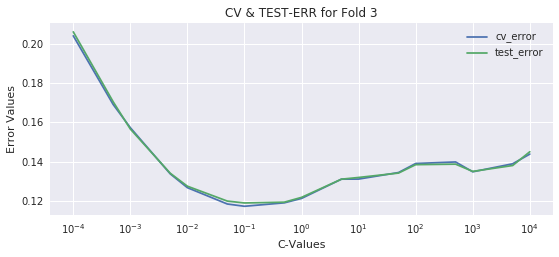

In [27]:
# cv error and test error for L2 normalization 
error_comparision(cv_l2_bow, test_l2_bow)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value near around 0.1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value rising becasue it overfits the model.

### [C.] Grid Search 

In [27]:
# finding best fit c using grid search (for L1)
grid_search_cv(final_counts, score, 'l1')

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8828225901138899


In [28]:
# finding best fit c using grid search (for L2)
grid_search_cv(final_counts, score, 'l2')

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8828129593696713


#### Observation:
* From grid-search we are getting optimal C equal to 0.5 for L1 Logistic Regression and the accuracy is 88.3%.
* From grid-search we are getting optimal C equal to 0.1 for L2 Logistic Regression and the accuracy is nearly same to the L1 accuracy score.

### [D.] Random Search 

In [29]:
# finding best fit c using random search (for L1) 
random_search_cv(final_counts, score, 'l1')

LogisticRegression(C=9.747002418284927, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8607765567765568


In [30]:
# finding best fit c using random search (for L2) 
random_search_cv(final_counts, score, 'l2')

LogisticRegression(C=9.546417367062102, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8717602115780193


#### Observation:
* From random-search we are getting optimal C equal to 9.7 for L1 Logistic Regression with accuracy equal to 86%.
* From random-search we are getting optimal C equal to 9.5 for L2 Logistic Regression with accuracy 87.2%.
* Overally, grid-search performed better here.

### [E.] Accuracy Matrics 


Test accuracy for C = '0.5' is '88.34996789820813'


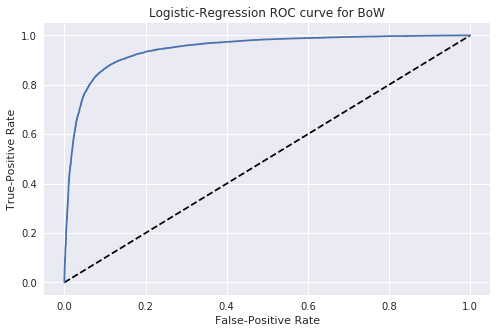

Area under the ROC curve is  0.9451917499312135

Confusion Matrix :
 [[15236  2007]
 [ 1985 15038]]

Normalized Confusion Matrix :
 [[0.88360494 0.11639506]
 [0.11660694 0.88339306]]


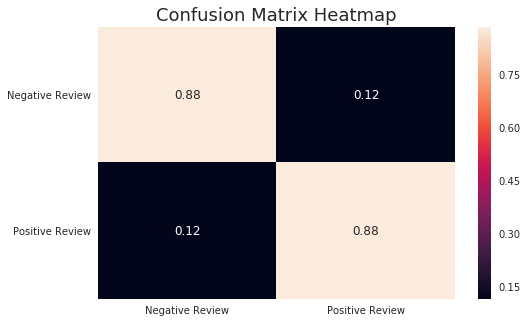

In [31]:
# accuracy measures for L1
final_test_acc(final_counts, score, 'l1', 0.5, 'BoW')

#### Observation:
* For L1 Logistic regression I choosed C to be 0.5 from grid-search and we got here accuracy equal to 88.35% for test-set.
* Area under the ROC curve is algo high(i.e 0.94) and false positive and false negative rates are also pretty low which is a good sign.


Test accuracy for C = '0.1' is '88.3674779664974'


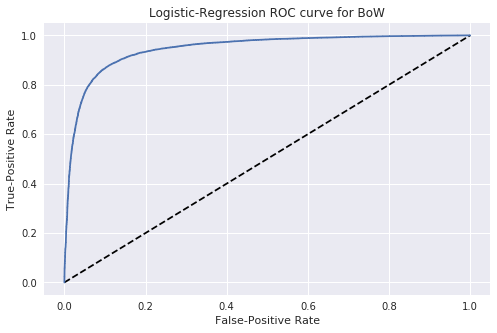

Area under the ROC curve is  0.9456734252670198

Confusion Matrix :
 [[15266  1977]
 [ 2009 15014]]

Normalized Confusion Matrix :
 [[0.88534478 0.11465522]
 [0.1180168  0.8819832 ]]


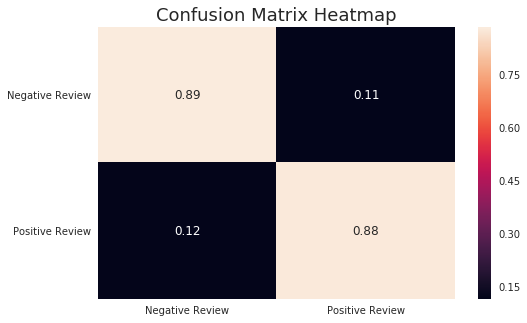

In [32]:
# accuracy measures for L2
final_test_acc(final_counts, score, 'l2', 0.1, 'BoW')

#### Observation:
* For L2 Logistic regression I choosed C to be 0.1 from grid-search and we got here accuracy equal to 88.37% for test-set.
* Area under the ROC curve is algo high(i.e 0.94) and false positive and false negative rates are also pretty low which is a good sign.
* So both L1 and L2 produced nearly same results.

### [F.] Multicollinearity Test

In [33]:
# multicollinearity severity testing 
multi_colinearity_test(final_counts, score, 0.1)

Euclidean distance between these two weight vectors is  7.955670684676045

Cosine similarity between these two weight vectors is  0.9267680629872332

i.e the angle between them is  22.06350788824524


#### Observation:
* After small perturbation I got new weight vector which is 7.95 unit away from the previous weight vector. The euclidean distance is pretty good i.e there no drastic change in weight vector due to perturbation.
* Also the Cosine similarity between them is also high i.e small angle(22 degree) between these two vectors.
* So, there is no major change in the weight vector due to perturbation. Hence, multicollinearity is low.
* That means we can use weight values to predict the feature(word) importance in our corpus.

### [G.] Top Features from Each Class

In [34]:
# printing top features(i.e words here) for each class
top_features(final_counts, score, count_vect, 10, 0.1)

Top 10 "NEGATIVE" Features are:

worst
terribl
aw
disappoint
horribl
tasteless
unfortun
threw
rip
mediocr

Top 10 "POSITIVE" Features are:

airpillow
candian
veggo
sanora
noddl
carpent
belgin
buscuit
drizzli
keept


### 6.1 Bag of Words (Bi-Gram)

In [35]:
#Adding both uni-gram and bi-gram to BoW
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(sorted_data['CleanedText'].values)

In [36]:
final_bigram_counts.shape

(114220, 1428081)

In [60]:
# column standardization 
#final_bigram_countsgram_counts = standardizer(final_bigram_counts)

I'm skipping the column standardization because without it the logistic regression performs a little bit better on this dataset.<br>
(I've already tested accuracy measures on standardized data, the above code here is only for demonstration purpose)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [37]:
# applying both L1 and L2 regularized logistic regression 
cv_l1_bigram, test_l1_bigram, cv_l2_bigram, test_l2_bigram, w_nonz  = logistic_regression(final_bigram_counts, score)

In [38]:
# reshaping the cv error and test error over 3-Fold cv
cv_l1_bi = np.reshape(cv_l1_bigram,(3, 17))
test_l1_bi = np.reshape(test_l1_bigram,(3, 17))
cv_l2_bi = np.reshape(cv_l2_bigram,(3, 17))
test_l2_bi = np.reshape(test_l2_bigram,(3, 17))

In [41]:
# effect of λ on sparsity of weight vector in L1 normalization 
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =         3
C =     0.0010      λ =  1000.0000      nonzero_w =        12
C =     0.0050      λ =   200.0000      nonzero_w =        95
C =     0.0100      λ =   100.0000      nonzero_w =       184
C =     0.0500      λ =    20.0000      nonzero_w =       647
C =     0.1000      λ =    10.0000      nonzero_w =      1104
C =     0.5000      λ =     2.0000      nonzero_w =      4739
C =     1.0000      λ =     1.0000      nonzero_w =      7770
C =     5.0000      λ =     0.2000      nonzero_w =     12183
C =    10.0000      λ =     0.1000      nonzero_w =     13322
C =    50.0000      λ =     0.0200      nonzero_w =     16731
C =   100.0000      λ =     0.0100      nonzero_w =     19440
C =   500.0000      λ =     0.0020      nonzero_w =     36969
C =  1000.0000      λ =     0.0010      nonzero_w =     47895
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

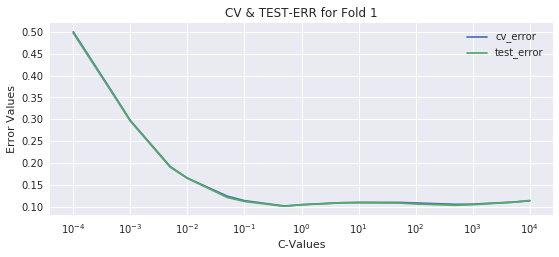

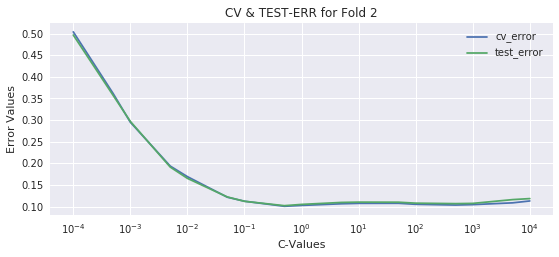

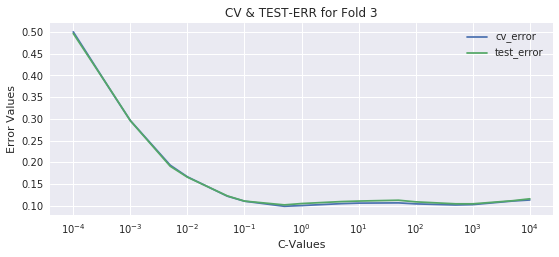

In [42]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_bi, test_l1_bi)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value little rising becasue it overfits the model.

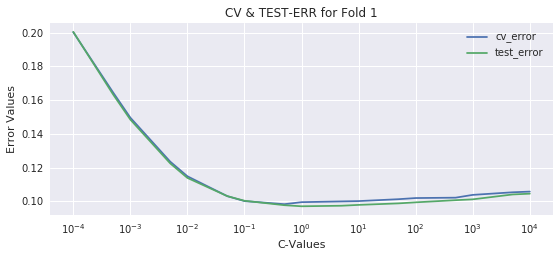

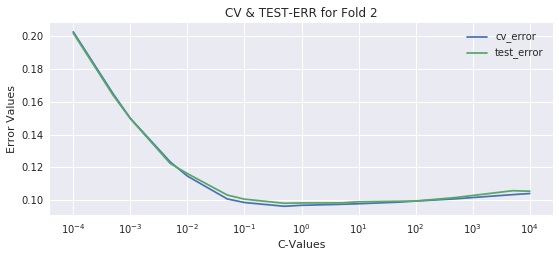

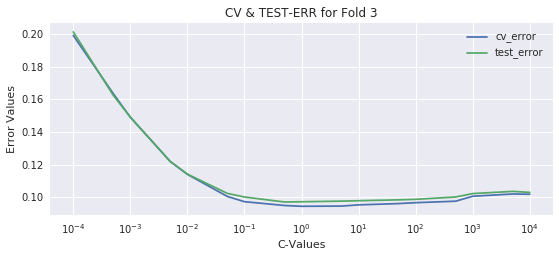

In [43]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_bi, test_l2_bi)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value ranging from 0.1 to 1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value little rising becasue it overfits the model.

### [C.] Grid Search 

In [44]:
# finding best fit c using grid search (for L1)
grid_search_cv(final_bigram_counts, score, 'l1')

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9017050273447783


In [45]:
# finding best fit c using grid search (for L2)
grid_search_cv(final_bigram_counts, score, 'l2')

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9059092507914176


#### Observation:
* From grid-search we are getting optimal C equal to 0.5 for L1 Logistic Regression and the accuracy is 90.2%.
* From grid-search we are getting optimal C equal to 0.5 for L2 Logistic Regression and the accuracy is nearly same(90.6%) to the L1 accuracy score.

### [D.] Random Search 

In [46]:
# finding best fit c using random search (for L1)
random_search_cv(final_bigram_counts, score, 'l1')

LogisticRegression(C=10.672161332068175, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8944284961040483


In [47]:
# finding best fit c using random search (for L2)
random_search_cv(final_bigram_counts, score, 'l2')

LogisticRegression(C=9.41988620531237, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.904859604900639


#### Observation:
* From random-search we are getting optimal C equal to 10.7 for L1 Logistic Regression with accuracy equal to 89.4%.
* From random-search we are getting optimal C equal to 9.4 for L2 Logistic Regression with accuracy 90.5%.
* Overally, grid-search performed better here.

### [E.] Accuracy Matrics 


Test accuracy for C = '0.5' is '90.1885250685811'


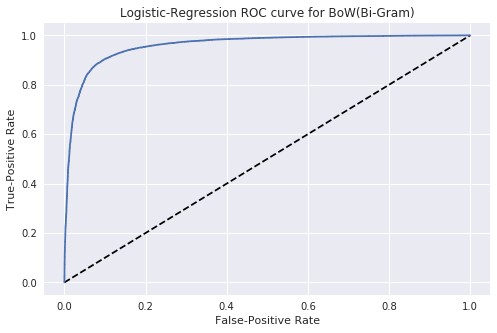

Area under the ROC curve is  0.9596237153026185

Confusion Matrix :
 [[15489  1754]
 [ 1608 15415]]

Normalized Confusion Matrix :
 [[0.89827756 0.10172244]
 [0.09446044 0.90553956]]


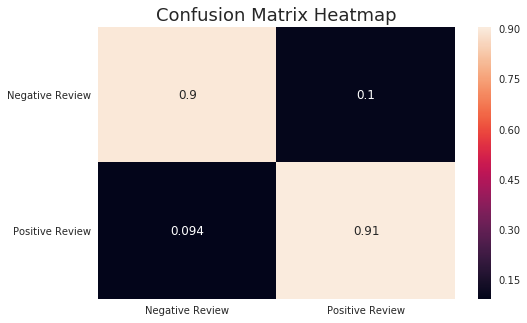

In [48]:
final_test_acc(final_bigram_counts, score, 'l1', 0.5, 'BoW(Bi-Gram)')

#### Observation:
* For L1 Logistic regression I choosed C to be 0.5 from grid-search and we got here accuracy equal to 90.2% for test-set.
* Area under the ROC curve is algo high(i.e 0.96) and false positive and false negative rates are also pretty low which is a good sign.


Test accuracy for C = '0.5' is '90.63211346524251'


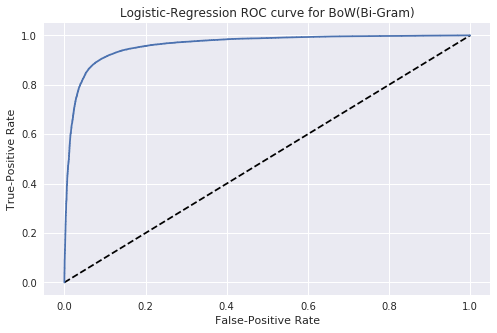

Area under the ROC curve is  0.9615030957107068

Confusion Matrix :
 [[15603  1640]
 [ 1570 15453]]

Normalized Confusion Matrix :
 [[0.90488894 0.09511106]
 [0.09222816 0.90777184]]


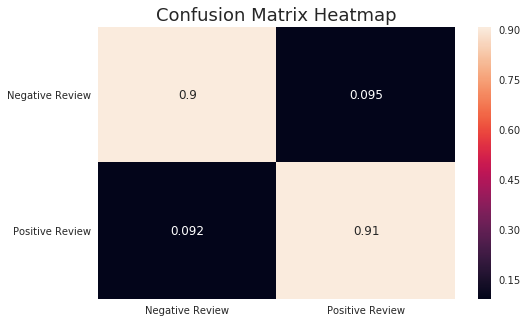

In [49]:
final_test_acc(final_bigram_counts, score, 'l2', 0.5, 'BoW(Bi-Gram)')

#### Observation:
* For L2 Logistic regression I choosed C to be 0.5 from grid-search and we got here accuracy equal to 90.6% for test-set.
* Area under the ROC curve is algo high(i.e 0.96) and false positive and false negative rates are also pretty low which is a good sign.

### [F.] Multicollinearity Test

In [50]:
# multicollinearity severity testing 
multi_colinearity_test(final_bigram_counts, score, 0.5)

Euclidean distance between these two weight vectors is  16.415706529793482

Cosine similarity between these two weight vectors is  0.9860914456350932

i.e the angle between them is  9.567165401032371


#### Observation:
* After small perturbation I got new weight vector which is 16.4 unit away from the previous weight vector. The euclidean distance is reasonable i.e there no drastic change in weight vector due to perturbation.
* Also the Cosine similarity between them is also high(0.98) i.e small angle(9.6 degree) between these two vectors.
* So, there is no major change in the weight vector due to perturbation. Hence, multicollinearity is low.
* That means we can use weight values to predict the feature(word) importance in our corpus.

### [G.] Top Features from Each Class

In [51]:
# printing top features(i.e words here) for each class
top_features(final_counts, score, count_vect, 10, 0.5)

Top 10 "NEGATIVE" Features are:

amend water
aid cat
amaz pleas
altura yet
although word
acai certain
adhes peel
alot give
ad miner
amaz expresso

Top 10 "POSITIVE" Features are:

whatev second
worldwid europ
whip look
whole stack
wholesom perfect
yummi product
wrong raspberri
witer
yellow acesulfam
whiskey bourbon


## 7. TF-IDF

In [30]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sorted_data['CleanedText'].values)

In [126]:
final_tf_idf.shape

(114220, 1428081)

In [79]:
#final_tf_idf = standardizer(final_tf_idf)

I'm skipping the column standardization because without it the logistic regression performs a little bit better on this dataset.<br>
(I've already tested accuracy measures on standardized data, the above code here is only for demonstration purpose)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [127]:
# applying both L1 & L2 Logistic Regression
cv_l1_tfidf, test_l1_tfidf, cv_l2_tfidf, test_l2_tfidf, w_nonz = logistic_regression(final_tf_idf, score)

In [128]:
cv_l1_tf = np.reshape(cv_l1_tfidf,(3, 17))
test_l1_tf = np.reshape(test_l1_tfidf,(3, 17))
cv_l2_tf = np.reshape(cv_l2_tfidf,(3, 17))
test_l2_tf = np.reshape(test_l2_tfidf,(3, 17))

In [129]:
# checking sparsity over different C
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =         0
C =     0.0010      λ =  1000.0000      nonzero_w =         0
C =     0.0050      λ =   200.0000      nonzero_w =         0
C =     0.0100      λ =   100.0000      nonzero_w =         3
C =     0.0500      λ =    20.0000      nonzero_w =        55
C =     0.1000      λ =    10.0000      nonzero_w =       128
C =     0.5000      λ =     2.0000      nonzero_w =       556
C =     1.0000      λ =     1.0000      nonzero_w =      1050
C =     5.0000      λ =     0.2000      nonzero_w =      6536
C =    10.0000      λ =     0.1000      nonzero_w =     10303
C =    50.0000      λ =     0.0200      nonzero_w =     14088
C =   100.0000      λ =     0.0100      nonzero_w =     14412
C =   500.0000      λ =     0.0020      nonzero_w =     21018
C =  1000.0000      λ =     0.0010      nonzero_w =     26082
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

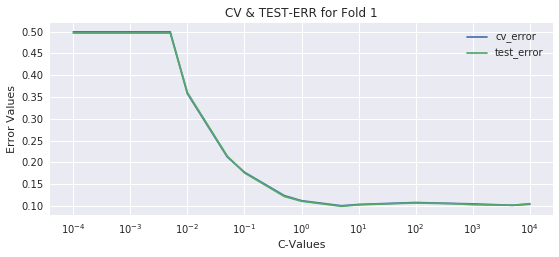

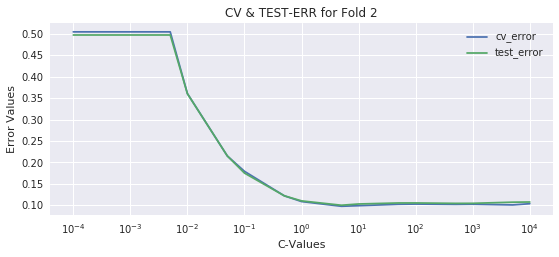

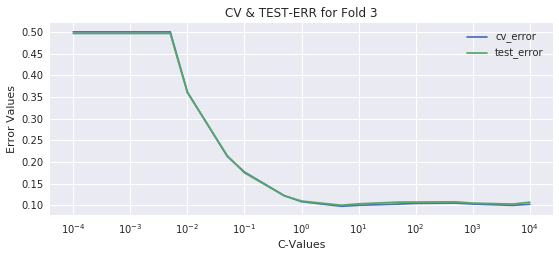

In [130]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_tf, test_l1_tf)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 10.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value little rising becasue it overfits the model.

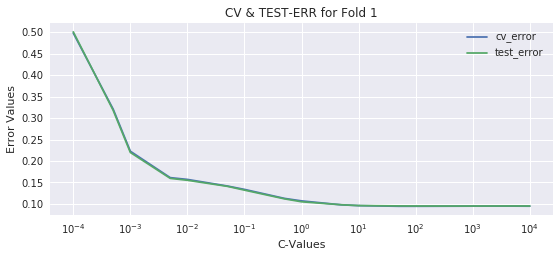

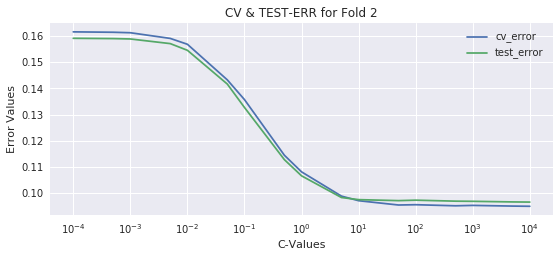

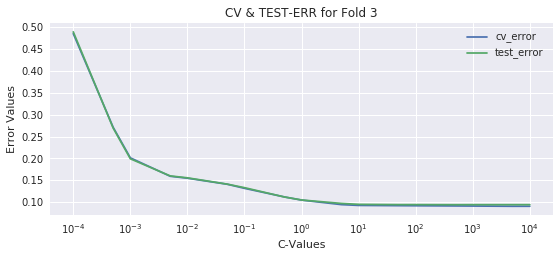

In [131]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_tf, test_l2_tf)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value ranging between 10 to 10000.

### [C.] Grid Search 

In [141]:
# finding best fit λ using grid search(L1)
grid_search_cv(final_tf_idf, score, 'l1')

LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9037637249721097


In [134]:
# finding best fit λ using grid search(L2)
grid_search_cv(final_tf_idf, score, 'l2')

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9078510331853855


#### Observation:
* From grid-search we are getting optimal C equal to 5 for L1 Logistic Regression and the accuracy is 90.4%.
* From grid-search we are getting optimal C equal to 10000 for L2 Logistic Regression and the accuracy is nearly same(90.8%) to the L1 accuracy score.

### [D.] Random Search 

In [139]:
# finding best fit λ using random search(L1)
random_search_cv(final_tf_idf, score, 'l1')

LogisticRegression(C=8.315357983194538, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9012918379330593


In [140]:
# finding best fit λ using random search(L2)
random_search_cv(final_tf_idf, score, 'l2')

LogisticRegression(C=11.064820781676591, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9070677931176593


#### Observation:
* From random-search we are getting optimal C equal to 8.3 for L1 Logistic Regression and the accuracy is 90.1%.
* From random-search we are getting optimal C equal to 11 for L2 Logistic Regression and the accuracy is nearly same(90.7%) to the L1 accuracy score.

### [E.] Accuracy Matrics 


Test accuracy for C = '5' is '90.43366602463084'


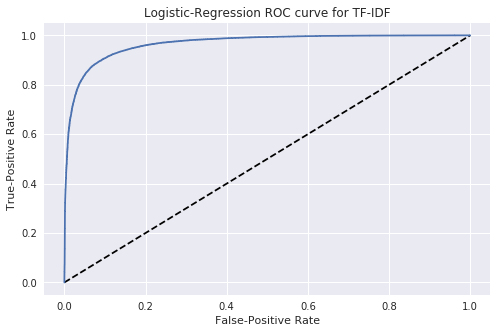

Area under the ROC curve is  0.9661137185302197

Confusion Matrix :
 [[15596  1647]
 [ 1631 15392]]

Normalized Confusion Matrix :
 [[0.90448298 0.09551702]
 [0.09581155 0.90418845]]


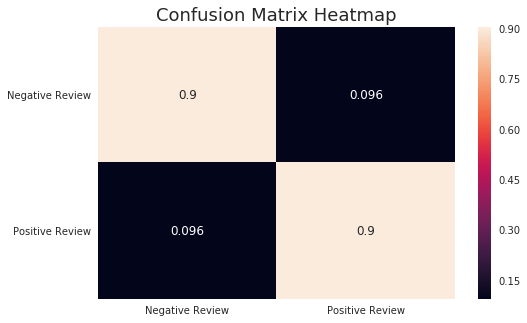

In [142]:
final_test_acc(final_tf_idf, score, 'l1', 5, 'TF-IDF')

#### Observation:
* For L1 Logistic regression I choosed C to be 5 from grid-search and we got here accuracy equal to 90.4% for test-set.
* Area under the ROC curve is algo high(i.e 0.97) and false positive and false negative rates are also pretty low which is a good sign.


Test accuracy for C = '11' is '90.78678573513103'


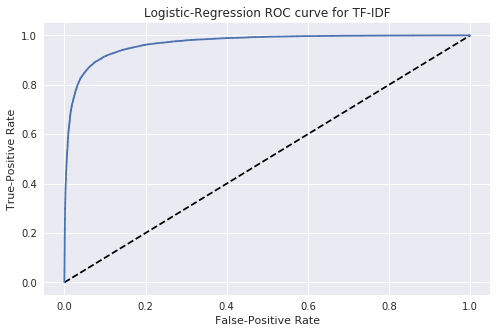

Area under the ROC curve is  0.9676011834785314

Confusion Matrix :
 [[15702  1541]
 [ 1616 15407]]

Normalized Confusion Matrix :
 [[0.9106304  0.0893696 ]
 [0.09493039 0.90506961]]


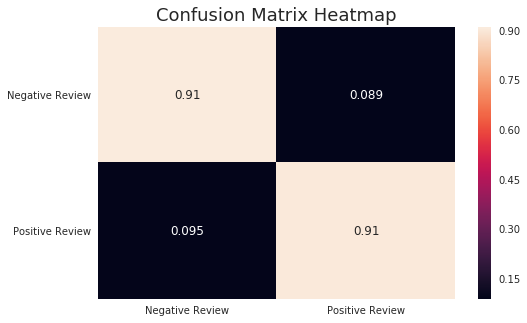

In [143]:
final_test_acc(final_tf_idf, score, 'l2', 11, 'TF-IDF')

#### Observation:
* For L2 Logistic regression I choosed C to be 11 from random-search and we got here accuracy equal to 90.8% for test-set.
* Area under the ROC curve is algo high(i.e 0.97) and false positive and false negative rates are also pretty low which is a good sign.

### [F.] Multicollinearity Test

In [144]:
# multicollinearity severity testing 
multi_colinearity_test(final_tf_idf, score, 11)

Euclidean distance between these two weight vectors is  4.797116646448619

Cosine similarity between these two weight vectors is  0.9999179869243612

i.e the angle between them is  0.7338075029278734


#### Observation:
* After small perturbation I got new weight vector which is 4.8 unit away from the previous weight vector. The euclidean distance is nearly close i.e there no drastic change in weight vector due to perturbation.
* Also the Cosine similarity between them is also very high(0.99) i.e very small angle(0.7 degree) between these two vectors.
* So, there is no major change in the weight vector due to perturbation. Hence, multicollinearity is very low.
* That means we can use weight values to predict the feature(word) importance in our corpus.

### [G.] Top Features from Each Class

In [145]:
# printing top features(i.e words here) for each class
top_features(final_tf_idf, score, tf_idf_vect, 10, 11)

Top 10 "NEGATIVE" Features are:

disappoint
worst
not
not worth
not good
aw
unfortun
terribl
not recommend
horribl

Top 10 "POSITIVE" Features are:

saw glucos
ago pepper
histori hypomag
heretofor imbib
highchair
verona coffe
beaba cant
buy kilo
hfcs ingredi
next pouch


## 8. Word2Vec

In [21]:
#Importing Libraries 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [22]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [23]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [24]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetlejuice!
['beetlejuice', 'is', 'an', 'excellent', 'and', 'funny', 'movie', 'keaton', 'is', 'hilarious', 'as', 'the', 'wacky', 'beetlejuice', 'the', 'great', 'special', 'effects', 'help', 'the', 'film', 'i', 'think', 'this', 'is', 'one', 'of', 'the', 'best', 'movies', 'ever', 'made', 'and', 'im', 'sure', 'youll', 'agree', 'for', 'a', 'good', 'time', 'watch', 'beetlejuice']


In [25]:
# creating own model
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=8)

In [26]:
words = list(w2v_model.wv.vocab)
print(len(words))

20878


## 9. Avg Word2Vec & TF-IDF Word2Vec

In [27]:
#Determining average Word2Vec for each review
sent_vectors = []
for sent in list_of_sent: 
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

114220
100


In [28]:
avg_word2vec = np.matrix(sent_vectors)

In [ ]:
#stnd_avg_word2vec = standardizer(avg_word2vec)
#stnd_avg_word2vec.shape

### [A.] Both L1 and L2 Normalized Logistic Regression

In [155]:
# applying both L1 & L2 Logistic Regression
cv_l1_w2v, test_l1_w2v, cv_l2_w2v, test_l2_w2v, w_nonz = logistic_regression(avg_word2vec, score)

In [156]:
cv_l1_wv = np.reshape(cv_l1_w2v,(3, 17))
test_l1_wv = np.reshape(test_l1_w2v,(3, 17))
cv_l2_wv = np.reshape(cv_l2_w2v,(3, 17))
test_l2_wv = np.reshape(test_l2_w2v,(3, 17))

In [157]:
# checking sparsity over different C for L1
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =         2
C =     0.0010      λ =  1000.0000      nonzero_w =        14
C =     0.0050      λ =   200.0000      nonzero_w =        44
C =     0.0100      λ =   100.0000      nonzero_w =        65
C =     0.0500      λ =    20.0000      nonzero_w =        83
C =     0.1000      λ =    10.0000      nonzero_w =        86
C =     0.5000      λ =     2.0000      nonzero_w =        96
C =     1.0000      λ =     1.0000      nonzero_w =        99
C =     5.0000      λ =     0.2000      nonzero_w =       100
C =    10.0000      λ =     0.1000      nonzero_w =       100
C =    50.0000      λ =     0.0200      nonzero_w =       100
C =   100.0000      λ =     0.0100      nonzero_w =       100
C =   500.0000      λ =     0.0020      nonzero_w =       100
C =  1000.0000      λ =     0.0010      nonzero_w =       100
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

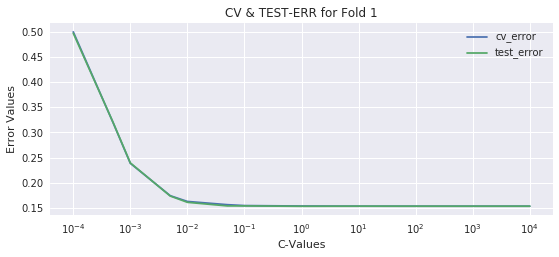

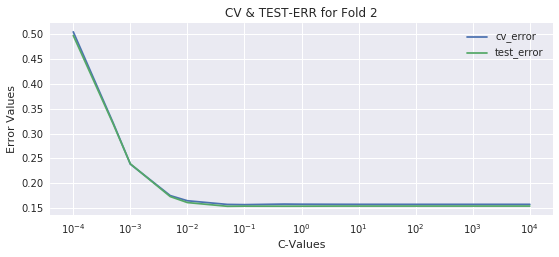

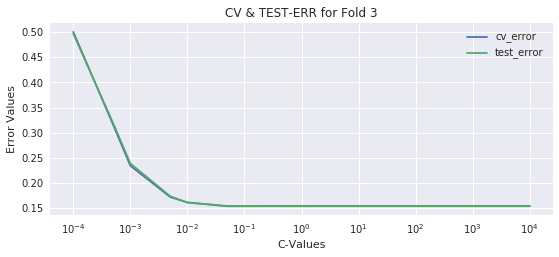

In [159]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_wv, test_l1_wv)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 0.1.

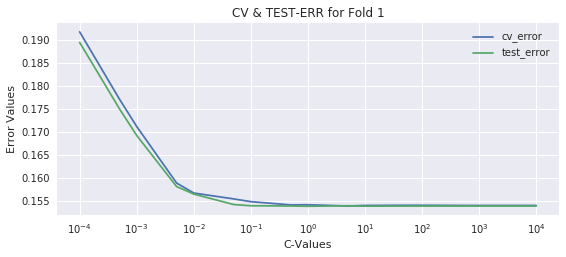

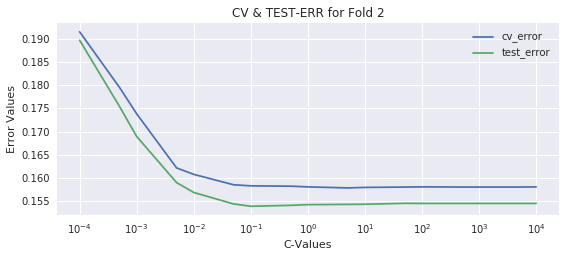

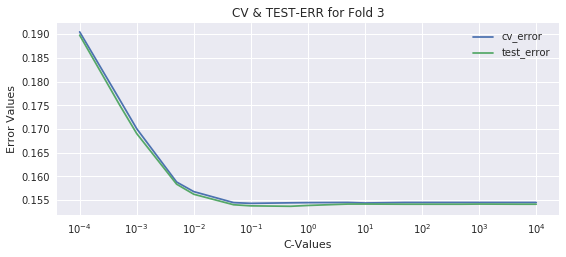

In [160]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_wv, test_l2_wv)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value near to 0.1.

### [C.] Grid Search 

In [161]:
# finding best fit C using grid search(L1) 
grid_search_cv(avg_word2vec, score, 'l1')

LogisticRegression(C=5000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8436103134898315


In [163]:
# finding best fit C using grid search(L2)
grid_search_cv(avg_word2vec, score, 'l2')

LogisticRegression(C=500.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8437194706770479


#### Observation:
* From grid-search we are getting optimal C equal to 5000 for L1 Logistic Regression and the accuracy is 84.4%.
* From grid-search we are getting optimal C equal to 500 for L2 Logistic Regression and the accuracy is equal to the L1 accuracy score.

### [D.] Random Search 

In [164]:
# finding best fit λ using random search 
random_search_cv(avg_word2vec, score, 'l1')

LogisticRegression(C=10.090052954745216, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8436103134898315


In [165]:
# finding best fit λ using random search 
random_search_cv(avg_word2vec, score, 'l2')

LogisticRegression(C=11.807050609782827, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8436695183683136


#### Observation:
* From random-search we are getting optimal C equal to 10 for L1 Logistic Regression and the accuracy is 84.4%.
* From random-search we are getting optimal C equal to 11.8 for L2 Logistic Regression and the accuracy is equal to the L1 accuracy score.

### [E.] Accuracy Matrics 


Test accuracy for C = '10' is '84.58530321601587'


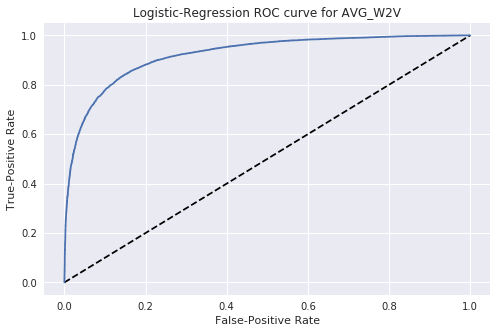

Area under the ROC curve is  0.9212473124630204

Confusion Matrix :
 [[14736  2507]
 [ 2775 14248]]

Normalized Confusion Matrix :
 [[0.85460767 0.14539233]
 [0.16301474 0.83698526]]


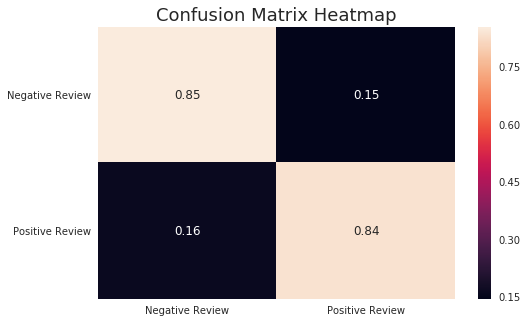

In [166]:
final_test_acc(avg_word2vec, score, 'l1', 10, 'AVG_W2V')

#### Observation:
* For L1 Logistic regression I choosed C to be 10 from random-search and we got here accuracy equal to 84.6% for test-set.
* Area under the ROC curve is 0.97 and false positive and false negative rates are also reasonable which is good.


Test accuracy for C = '12' is '84.58822156073076'


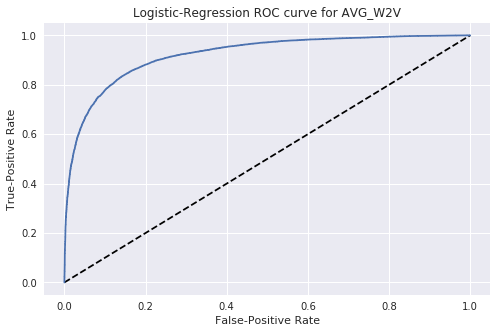

Area under the ROC curve is  0.9212512269161861

Confusion Matrix :
 [[14735  2508]
 [ 2773 14250]]

Normalized Confusion Matrix :
 [[0.85454967 0.14545033]
 [0.16289726 0.83710274]]


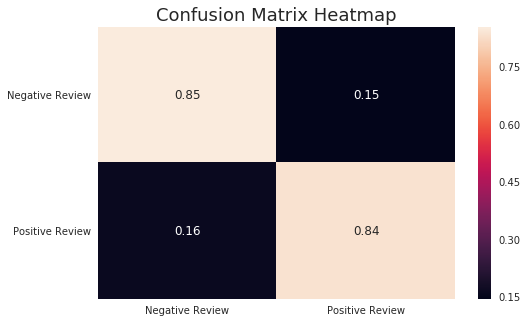

In [167]:
final_test_acc(avg_word2vec, score, 'l2', 12, 'AVG_W2V')

#### Observation:
* For L2 Logistic regression I choosed C to be 12 from random-search and we got here accuracy equal to 84.6% for test-set.
* Area under the ROC curve is 0.92 and false positive and false negative rates are also reasonable which is good.

### 9.1 TF-IDF weighted Word2Vec

In [32]:
# Determining TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors = []
row = 0
for sent in list_of_sent[:10000]: 
    sent_vec = np.zeros(100)
    weight_sum = 0 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [45]:
tfidf_word2vec = np.matrix(tfidf_sent_vectors)

In [47]:
tfidf_word2vec.shape

(10000, 100)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [57]:
# applying L1 & L2 Logistic Regression
cv_l1_tfidf_w2v, test_l1_tfidf_w2v, cv_l2_tfidf_w2v, test_l2_tfidf_w2v, w_nonz = logistic_regression(tfidf_word2vec, score[:10000])

In [58]:
cv_l1_tfidf_wv = np.reshape(cv_l1_tfidf_w2v,(3, 17))
test_l1_tfidf_wv = np.reshape(test_l1_tfidf_w2v,(3, 17))
cv_l2_tfidf_wv = np.reshape(cv_l2_tfidf_w2v,(3, 17))
test_l2_tfidf_wv = np.reshape(test_l2_tfidf_w2v,(3, 17))

In [59]:
# checking sparsity over different C for L1
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =         0
C =     0.0010      λ =  1000.0000      nonzero_w =         0
C =     0.0050      λ =   200.0000      nonzero_w =         7
C =     0.0100      λ =   100.0000      nonzero_w =        16
C =     0.0500      λ =    20.0000      nonzero_w =        53
C =     0.1000      λ =    10.0000      nonzero_w =        74
C =     0.5000      λ =     2.0000      nonzero_w =        91
C =     1.0000      λ =     1.0000      nonzero_w =        94
C =     5.0000      λ =     0.2000      nonzero_w =        98
C =    10.0000      λ =     0.1000      nonzero_w =        99
C =    50.0000      λ =     0.0200      nonzero_w =       100
C =   100.0000      λ =     0.0100      nonzero_w =       100
C =   500.0000      λ =     0.0020      nonzero_w =       100
C =  1000.0000      λ =     0.0010      nonzero_w =       100
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

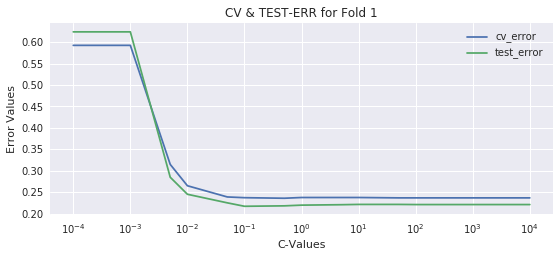

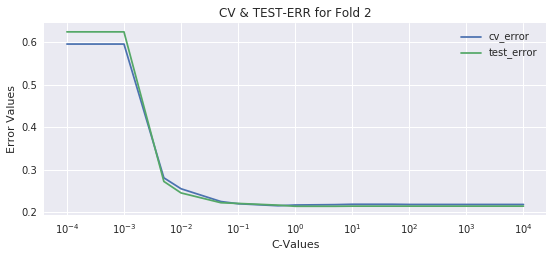

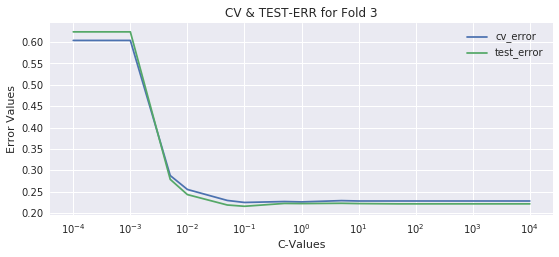

In [60]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_tfidf_wv, test_l1_tfidf_wv)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 0.1.

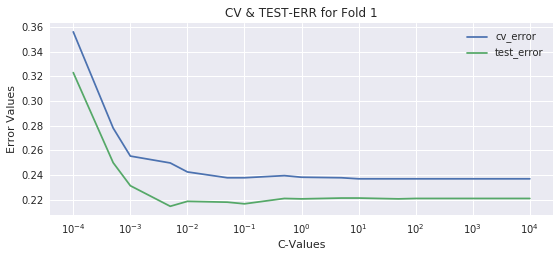

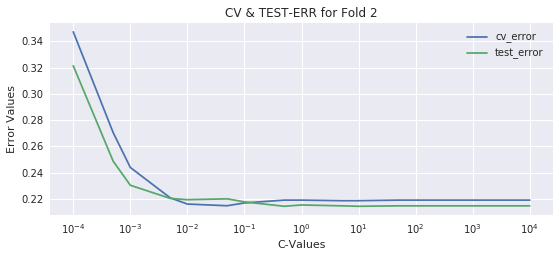

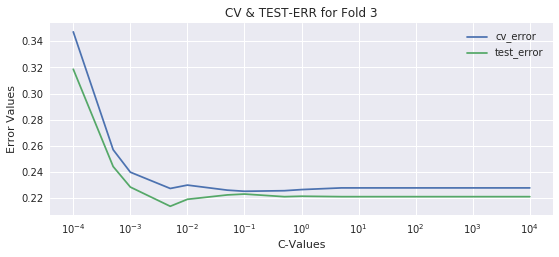

In [61]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_tfidf_wv, test_l2_tfidf_wv)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value near to 0.01.

### [C.] Grid Search 

In [62]:
# finding best fit C using grid search(L1) 
grid_search_cv(tfidf_word2vec, score[:10000], 'l1')

LogisticRegression(C=50.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8296023176191731


In [63]:
# finding best fit C using grid search(L2)
grid_search_cv(tfidf_word2vec, score[:10000], 'l2')

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8343717549325025


#### Observation:
* From grid-search we are getting optimal C equal to 50 for L1 Logistic Regression and the accuracy is 83%.
* From grid-search we are getting optimal C equal to 0.01 for L2 Logistic Regression and the accuracy is nearly equal(83.4%) to the L1 accuracy score.

### [D.] Random Search 

In [64]:
# finding best fit C using random search(L1)
random_search_cv(tfidf_word2vec, score[:10000], 'l1')

LogisticRegression(C=9.295713802679954, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8296920242168992


In [65]:
# finding best fit C using random search(L2)
random_search_cv(tfidf_word2vec, score[:10000], 'l2')

LogisticRegression(C=9.782472739936987, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8296023176191731


#### Observation:
* From random-search we are getting optimal C equal to 9.3 for L1 Logistic Regression and the accuracy is 83%.
* From random-search we are getting optimal C equal to 9.8 for L2 Logistic Regression and the accuracy is equal to the L1 accuracy score.

### [E.] Accuracy Matrics 


Test accuracy for C = '9.3' is '78.43333333333334'


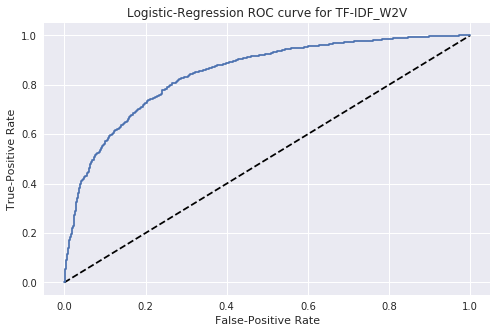

Area under the ROC curve is  0.845677433775838

Confusion Matrix :
 [[ 777  351]
 [ 296 1576]]

Normalized Confusion Matrix :
 [[0.68882979 0.31117021]
 [0.15811966 0.84188034]]


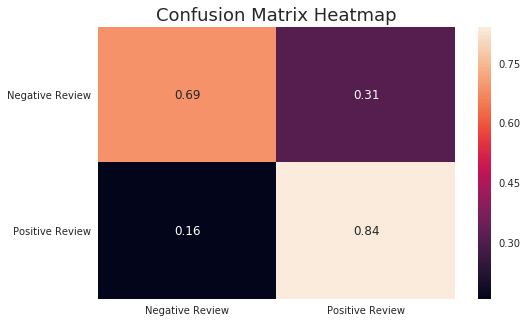

In [72]:
final_test_acc(tfidf_word2vec, score[:10000], 'l1', 9.3, 'TF-IDF_W2V')

#### Observation:
* For L1 Logistic regression I choosed C to be 9.8 from random-search and we got here accuracy equal to 78.4% for test-set which is ok but not that good.
* Area under the ROC curve is 0.84 but false negative rate is high, that means for TF-IDF weighted word2vec representation our model becomes little biased towards positive class which is not good.


Test accuracy for C = '0.01' is '78.73333333333333'


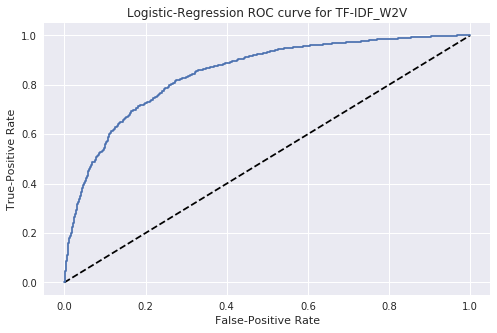

Area under the ROC curve is  0.8464081537552283

Confusion Matrix :
 [[ 755  373]
 [ 265 1607]]

Normalized Confusion Matrix :
 [[0.66932624 0.33067376]
 [0.14155983 0.85844017]]


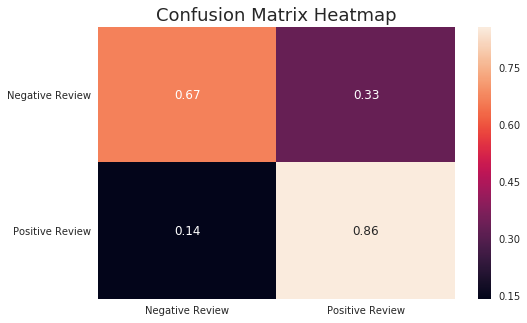

In [73]:
final_test_acc(tfidf_word2vec, score[:10000], 'l2', 0.01, 'TF-IDF_W2V')

#### Observation:
* For L2 Logistic regression I choosed C to be 0.01 from grid-search and we got here accuracy equal to 78.8%.
* Area under the ROC curve is 0.84 but again false negative rate is high, that means for TF-IDF weighted word2vec representation our model becomes little biased towards positive class which is bad.

## 10. Conclusion:
* Both Bag of Words(Bi-Gram) and TF-IDF representaion worked well here for Logistic Regression.
* The highest accuracy obtained by our model is 90.8% for TF-IDF representaion.
* Both Avg. Word2Vec and TF-IDF weighted Word2Vec did not perform well as they produced more over biased output towards positive class.